# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
import os
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path

from urbanmask.urban_areas import (
    Urban_vicinity,
)

from urbanmask.UHI_plot_functions import (
    plot_climatology,
    plot_time_series
)

from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

In [2]:
city = 'PortoAlegre'
lon_city = -51.2090
lat_city = -30.0368

domain = 'CSAM-4'
model = 'WRF433'
scenario = "evaluacion"

urban_th = 60
urban_sur_th = 1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 6
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [3]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [4]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [5]:
root = "/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/"

In [6]:
ds_sftuf = xr.open_dataset(f'{root}fx/landuse/landuse_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx.nc')
ds_orog = xr.open_dataset(f'{root}fx/orog/orog_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx.nc')
ds_sftlf = xr.open_dataset(f'{root}fx/sftlf/sftlf_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx.nc')

ds_sftuf['sftuf'] = (ds_sftuf['landuse'] == 13)*100

Add parameters to the function

In [7]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain)

Crop area around de city

In [8]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [9]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [10]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

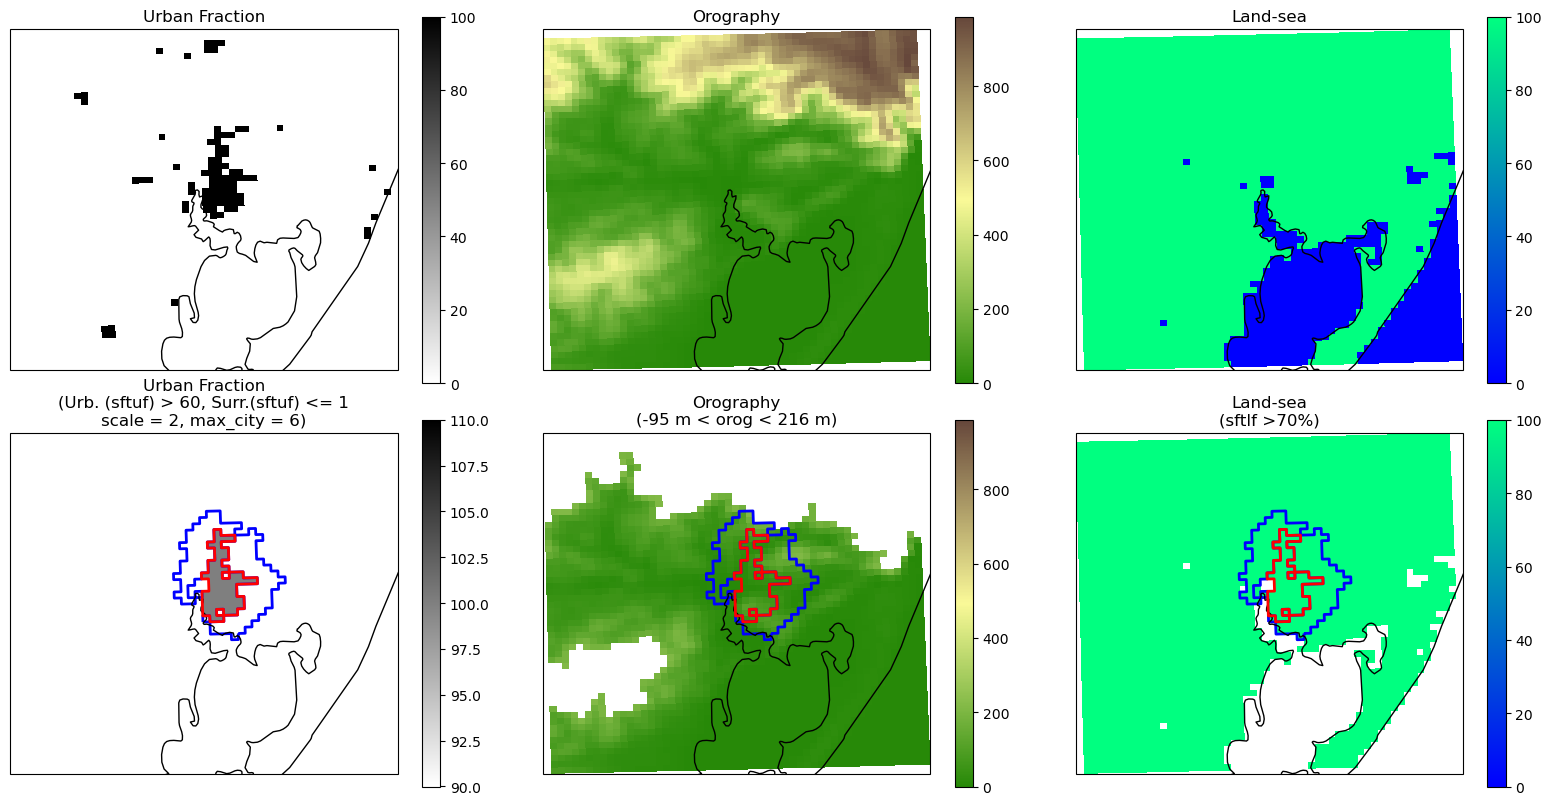

In [11]:
fig = URBAN.plot_static_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [12]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")
ds_sftuf.rename_vars({'sftuf': 'sfturf'}).to_netcdf(f"{output_dir}/sfturf_{base_filename}_fx.nc")

## Calculate urban heat island effect

### Load climate variable

In [13]:
variable = 'tasmin'

In [14]:
files = np.sort(list(traverseDir(root + 'day/tasmin/')))
ds_RCM = xr.open_mfdataset(files, concat_dim = 'time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

### Compute the climatology of anomalies with respect to rural vicinity mean

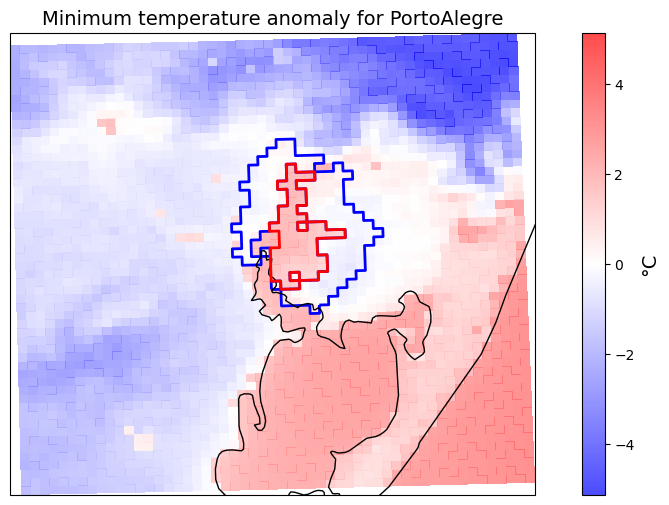

In [15]:
fig = plot_climatology(ds_RCM, urmask, variable, URBAN,
                       city = city,
                       alpha_urb_borders = 1,
                       linewidth_urb_borders = 0.6
                      )
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

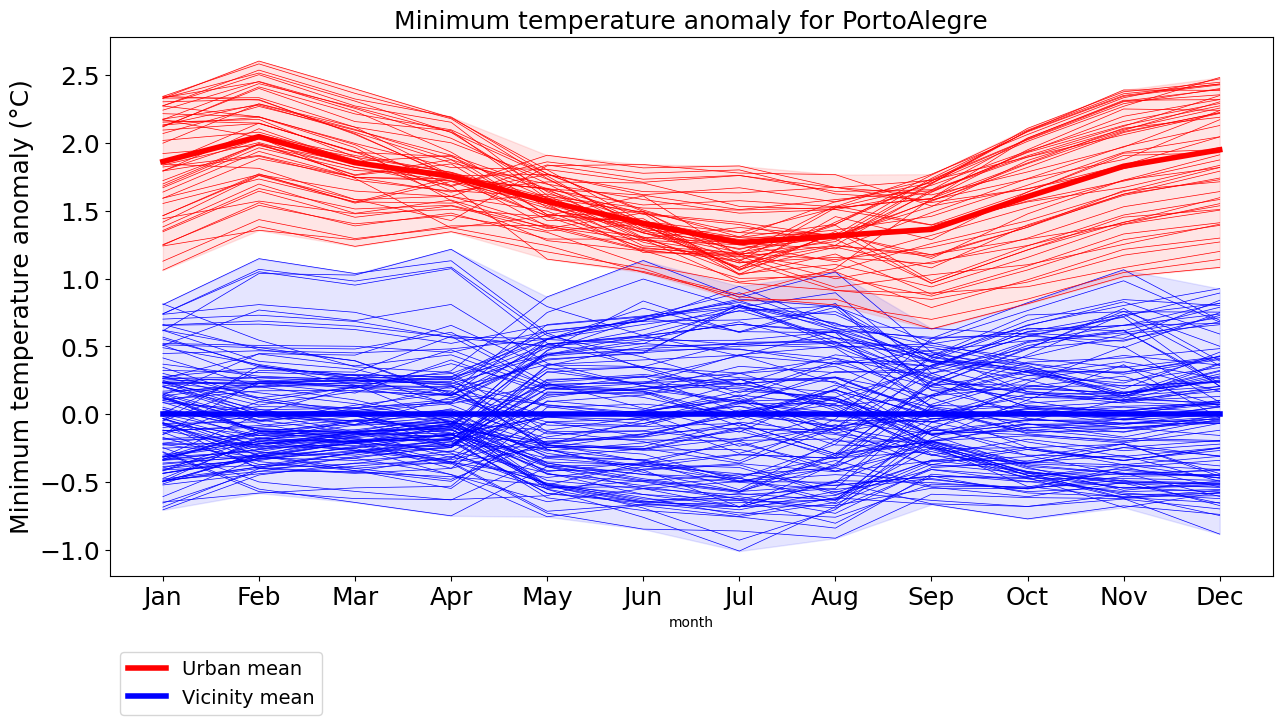

In [16]:
cachefile = f"{output_dir}/{variable}_{base_filename}_acycle-ur.nc"
fig = plot_time_series(ds_RCM, variable, urmask, 
    data_squares = True, city = city, cache= cachefile)
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')